In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix,f1_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.callbacks import ModelCheckpoint



In [3]:
SEED = 12
BATCH_SIZE = 512
EPOCHS = 130
LR =  0.0001
NUM_CLASSES = 14
train_dir = "./drive/MyDrive/train_dataset3.npz"
# test_dir = "./drive/MyDrive/test_dataset3.npz"
IMG_HEIGHT = 64
IMG_WIDTH = 64
checkpoint_path = "./drive/MyDrive/checkpoints/hybrid_vit_checkpoint.keras"

In [4]:
# Load dataset
data_train = np.load(train_dir)
# data_test = np.load(test_dir)
# X = data_train['X']
# X_test = data_test['X']
# y = data_train['y']
# y_test = data_test['y']
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"Normal",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']
class_names=data_train['class_names']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data_train['X'], data_train['y'], test_size=0.2, random_state=42)

print(f"Loaded dataset:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


Loaded dataset:
X_train shape: (52800, 64, 64, 3)
X_test shape: (13200, 64, 64, 3)


In [7]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input
train_datagen = ImageDataGenerator(
                                  preprocessing_function=preprocess_fun
                                 )
train_generator=train_datagen.flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    shuffle = True
)
test_datagen = ImageDataGenerator(
                                  preprocessing_function=preprocess_fun
                                 )
test_generator = test_datagen.flow(X_test,
                                   y_test,
                                   batch_size = BATCH_SIZE,
                                   shuffle  = True
                                                  )

batch = train_generator[0]  # The first batch from the generator
sample_image = batch[0][0]  # Take the first image in the batch

print("Sample image shape:", sample_image.shape)
print("Pixel range (min, max):", sample_image.min(), sample_image.max())

test_batch = test_generator[0]  # The first batch from the test generator
test_sample_image = test_batch[0][0]  # Take the first image in the batch

print("Test sample image shape:", test_sample_image.shape)
print("Pixel range (min, max):", test_sample_image.min(), test_sample_image.max())

Sample image shape: (64, 64, 3)
Pixel range (min, max): -2.117904 2.622571
Test sample image shape: (64, 64, 3)
Pixel range (min, max): -2.117904 2.64


In [9]:
def create_hybrid_vit_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    # 1. CNN Feature Extractor
    cnn_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(cnn_input)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    cnn_features = layers.Dense(128, activation='relu')(x)

    # 2. Transformer Input: Patch Embeddings
    image_size = input_shape[0]
    patch_size = 6
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64

    # Adjust the CNN output to match num_patches * projection_dim
    adjusted_dim = num_patches * projection_dim
    cnn_features = layers.Dense(adjusted_dim, activation='relu')(cnn_features)

    # Reshape into patches
    patches = layers.Reshape((num_patches, projection_dim))(cnn_features)

    # 3. Positional Encoding
    # Replace the random positional encoding with a trainable embedding layer
    position_embedding_layer = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    # Generate trainable positional embeddings
    positions = tf.range(start=0, limit=num_patches, delta=1)  # Sequence of positions [0, 1, ..., num_patches - 1]
    position_embedding = position_embedding_layer(positions)
    embedded_patches = patches + position_embedding

    # 4. Transformer Layers
    for _ in range(12):  # 8 transformer layers
        attention_output = layers.MultiHeadAttention(num_heads=8, key_dim=projection_dim)(
            embedded_patches, embedded_patches
        )
        attention_output = layers.Add()([attention_output, embedded_patches])  # Residual connection
        attention_output = layers.LayerNormalization()(attention_output)

        mlp_output = layers.Dense(projection_dim * 2, activation='relu')(attention_output)
        mlp_output = layers.Dense(projection_dim)(mlp_output)
        embedded_patches = layers.Add()([mlp_output, attention_output])  # Residual connection
        embedded_patches = layers.LayerNormalization()(embedded_patches)

    # 5. Classification Head
    representation = layers.GlobalAveragePooling1D()(embedded_patches)
    mlp_head = layers.Dense(1024, activation='relu')(representation)
    mlp_head = layers.Dense(512, activation='relu')(mlp_head)
    output = layers.Dense(num_classes, activation='softmax')(mlp_head)

    hybrid_vit_model = Model(inputs=cnn_input, outputs=output, name="Hybrid_CNN_ViT")
    return hybrid_vit_model


In [10]:
# Instantiate and compile the model
hybrid_vit = create_hybrid_vit_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES)
hybrid_vit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])


# Summarize the model
hybrid_vit.summary()

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {cls: class_weights[idx] for idx, cls in enumerate(np.unique(y_train))}

# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True
# )
# datagen.fit(X_train)


# Train the model
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

def balanced_data_generator(minority_generators, majority_generator, class_weights_dict):
    while True:
        # Get a batch from the majority generator
        majority_batch = next(majority_generator)

        # Get a batch from each minority class generator
        minority_batch = {}
        for label in minority_class_labels:
            minority_batch[label] = next(minority_generators[label])

        # Combine the batches for each class
        X_batch = np.concatenate([majority_batch[0]] + [minority_batch[label][0] for label in minority_class_labels])
        y_batch = np.concatenate([majority_batch[1]] + [minority_batch[label][1] for label in minority_class_labels])

        # Create sample weights based on the class weights
        sample_weights = np.array([class_weights_dict[int(label)] for label in y_batch])

        # Shuffle the combined batch
        indices = np.arange(len(y_batch))
        np.random.shuffle(indices)

        # Yield shuffled combined batches along with sample weights
        yield X_batch[indices], y_batch[indices], sample_weights[indices]

#train_generator = balanced_data_generator(minority_generators, majority_generator, class_weights_dict)

#Update ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,  # Path to save the checkpoint
    save_best_only=True,       # Only save the best model based on validation loss
    monitor='val_loss',        # Monitor validation loss
    mode='min',                # Save model with minimum validation loss
    verbose=1
)

history = hybrid_vit.fit(
    x=train_generator,  # Use the balanced generator
    validation_data=test_generator,  # Use test generator as before
    epochs=EPOCHS,
    callbacks=[early_stopping,checkpoint],
    class_weight=class_weights_dict  )



Model: "Hybrid_CNN_ViT"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 62, 62, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 31, 31, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 29, 29, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 14, 14, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 12544)          │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │      1,605,760 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 6400)           │        825,600 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 100, 64)        │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 100, 64)        │              0 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 100, 64)        │        132,672 │ add[0][0], add[0][0]   │
│ (MultiHeadAttention)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 100, 64)        │              0 │ multi_head_attention[… │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 100, 64)        │            128 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 100, 128)       │          8,320 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 100, 64)        │          8,256 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 100, 64)        │              0 │ dense_3[0][0],         │
│                           │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1

 Total params: 4,843,342 (18.48 MB)

 Trainable params: 4,843,342 (18.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/130
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.4197 - loss: 1.8684
Epoch 1: val_loss improved from inf to 0.43485, saving model to ./drive/MyDrive/checkpoints/hybrid_vit_checkpoint.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.4218 - loss: 1.8616 - val_accuracy: 0.8636 - val_loss: 0.4348
Epoch 2/130
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.9446 - loss: 0.1379
Epoch 2: val_loss improved from 0.43485 to 0.08536, saving model to ./drive/MyDrive/checkpoints/hybrid_vit_checkpoint.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 74s 711ms/step - accuracy: 0.9448 - loss: 0.1375 - val_accuracy: 0.9794 - val_loss: 0.0854
Epoch 3/130
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9822 - loss: 0.0521
Epoch 3: val_loss improved from 0.08536 to 0.04624, saving model to ./drive/MyDrive/checkpoints/hybrid_vit_checkpoint.keras
104/104 ━━━━━━━━━━━━━━━━━━━━ 76s 714ms/step - accuracy: 0.9822 - loss: 0.0521 - val_accuracy: 0.9871 - val_loss: 0.0462
Epoch 4

In [11]:
# Save the model
hybrid_vit.save('./drive/MyDrive/hybrid_vit_modelnew.h5')


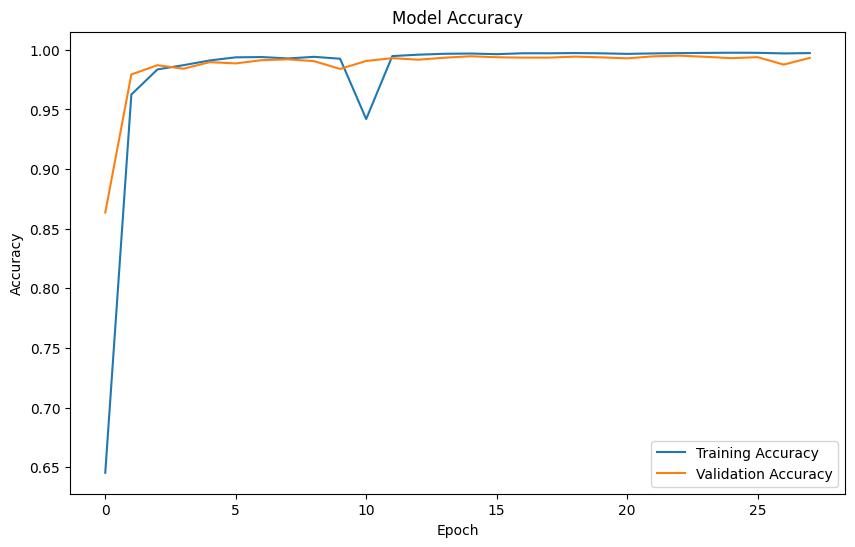

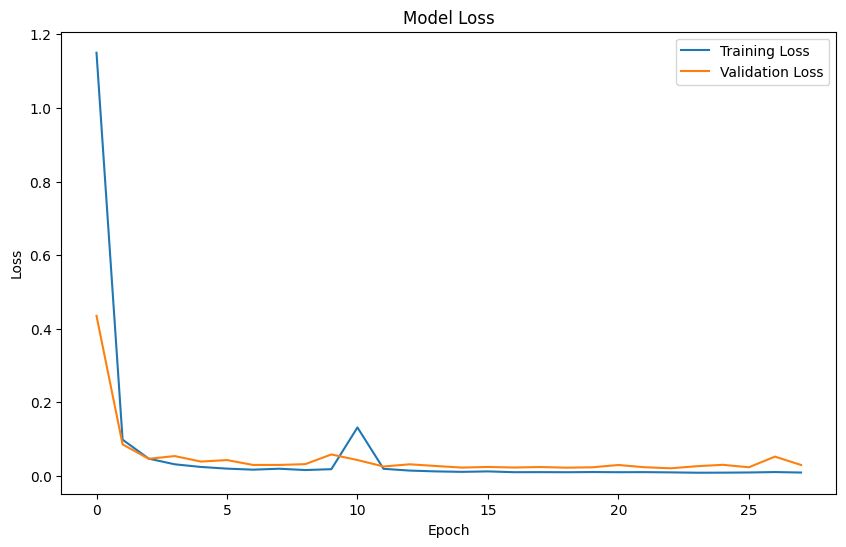

In [12]:
# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


413/413 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step


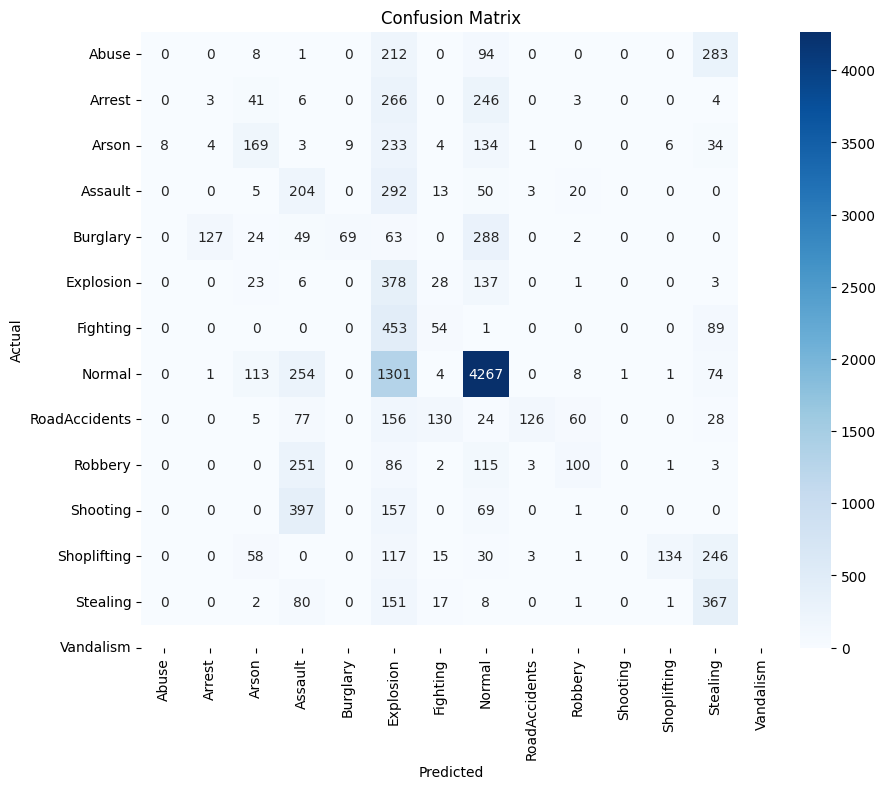

classification_report
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       598
           1       0.02      0.01      0.01       569
           2       0.38      0.28      0.32       605
           3       0.15      0.35      0.21       587
           4       0.88      0.11      0.20       622
           5       0.10      0.66      0.17       576
           6       0.20      0.09      0.12       597
           7       0.78      0.71      0.74      6024
           8       0.93      0.21      0.34       606
           9       0.51      0.18      0.26       561
          11       0.00      0.00      0.00       624
          12       0.94      0.22      0.36       604
          13       0.32      0.59      0.42       627

    accuracy                           0.44     13200
   macro avg       0.40      0.26      0.24     13200
weighted avg       0.56      0.44      0.45     13200



In [13]:
# Generate predictions and convert them to class indices
y_pred = hybrid_vit.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("classification_report\n", classification_report(y_test, y_pred_classes))


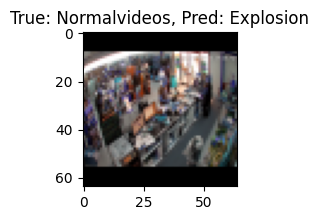

In [15]:
def plot_sample_with_prediction(X, y_true, y_pred, index):
    plt.figure(figsize=(3, 2))
    plt.imshow(X[index])
    plt.title(f"True: {class_names[y_true[index]]}, Pred: {class_names[y_pred[index]]}")
    plt.show()

plot_sample_with_prediction(X_test, y_test, y_pred_classes, 5)


In [17]:

# Calculate and print macro F1 score
f1_macro = f1_score(y_test, y_pred_classes, average='macro')
print(f'Macro F1 Score: {f1_macro}')

Macro F1 Score: 0.24289461429030498
